Descarga y extracción de imágenes

In [1]:
!wget -q https://www.dropbox.com/scl/fi/3p82v6b4n17x8vy1d3qx9/2025clock.zip?rlkey=ieleolj3up1kon5pm0y4h5dek -O 2025clock.zip
!unzip -q 2025clock.zip
!rm 2025clock.zip

replace clock_05.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Primero voy a mostrar las imágenes originales extraidas para ver si se cargaron bien y ver como son:

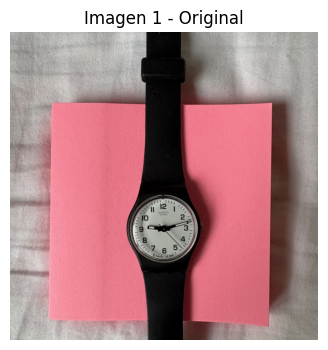

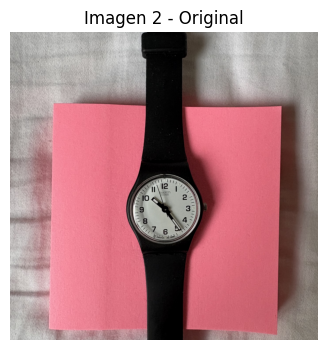

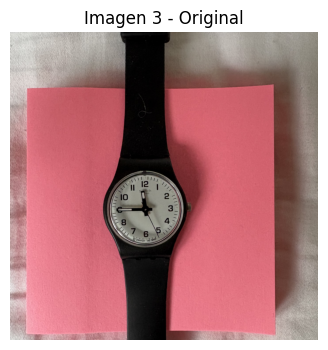

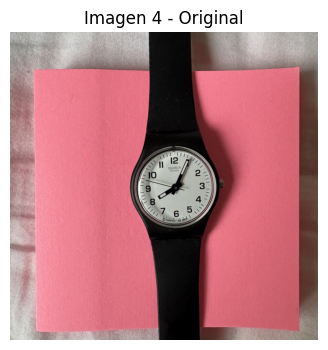

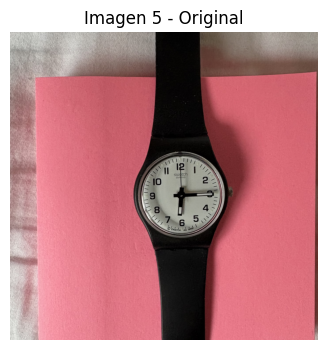

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i in range(1,6):
    path = f"clock_0{i}.png"
    X = mpimg.imread(path)

    plt.figure(figsize=(4,4))
    plt.imshow(X)
    plt.axis('off')
    plt.title(f"Imagen {i} - Original")
    plt.show()

Ahora voy a convertir a escala de grises las 5 imagenes y normalizar para luego poder segmentar la imagen segun sus tonos de grises.

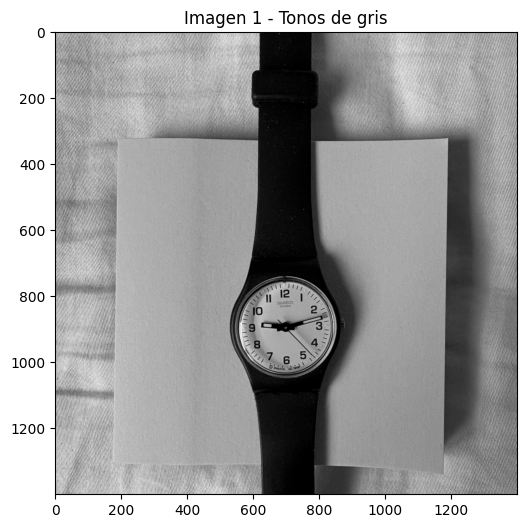

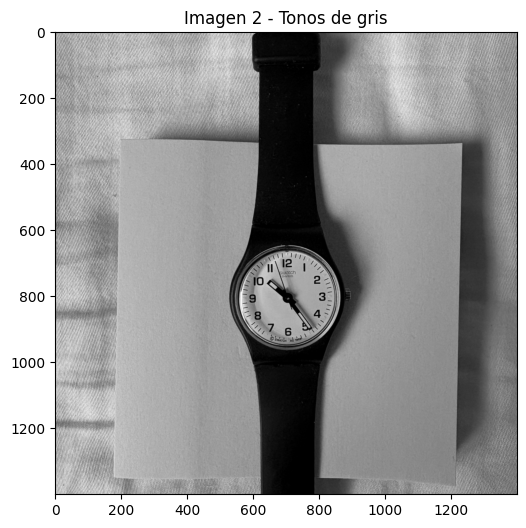

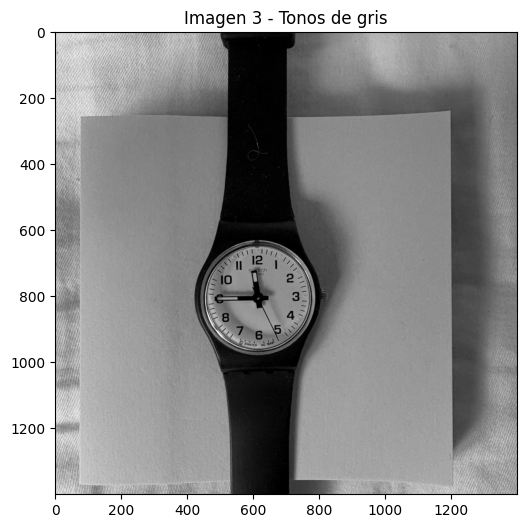

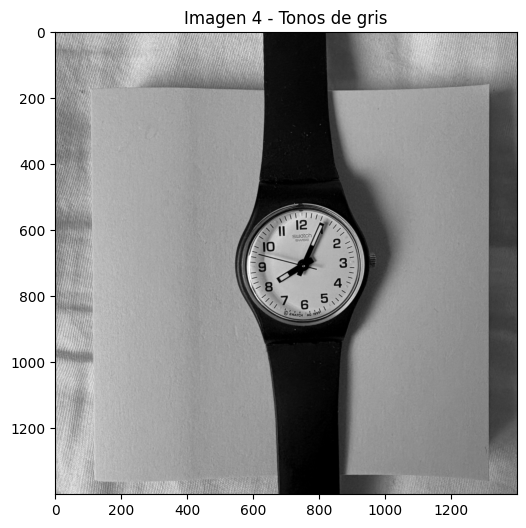

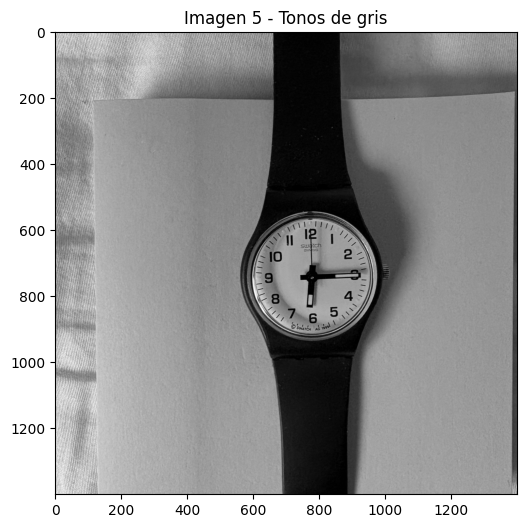

In [3]:
import numpy as np
from matplotlib.image import imread

X_grises = []  # Lista para guardar imágenes en gris

for i in range(1,6):
    path = f"clock_0{i}.png"
    X = imread(path)

    #Convertir a gris si tiene 3 canales (RGB)
    if X.ndim == 3:
        X = X.mean(axis=2)

    X = (X * 255).astype(np.uint8)  # Escala 0-255

    #Normalización para garantizar rango 0-255
    Xf = X.astype(float)
    X_gray = 255 * ((Xf - Xf.min()) / (Xf.max() - Xf.min()))
    X_gray = X_gray.astype(np.uint8)

    X_grises.append(X_gray)

    # Mostrar imagen en gris
    plt.figure(figsize=(6,6))
    plt.imshow(X_gray, cmap='gray')
    plt.title(f'Imagen {i} - Tonos de gris')
    plt.show()

Ahora voy a hacer una segmentacion para dejar solo los pixeles mas oscuros de la imagen, ya que de esta forma dejo solo las parte del reloj ya que las correas de este, las manecillas y nuemros son negros. Para definir el umbral tuve que ir iterando hasta llegar a un resultado en donde en las imagenes no se eliminaran ni las manecillas ni gran parte del reloj y donde la gran mayoria de los pixeles del fondo que fuesen medio oscuros tampoco apreciesen. parti con un umbral de 50 pero iterando el que quedaba mejor era con un umbral de 35.

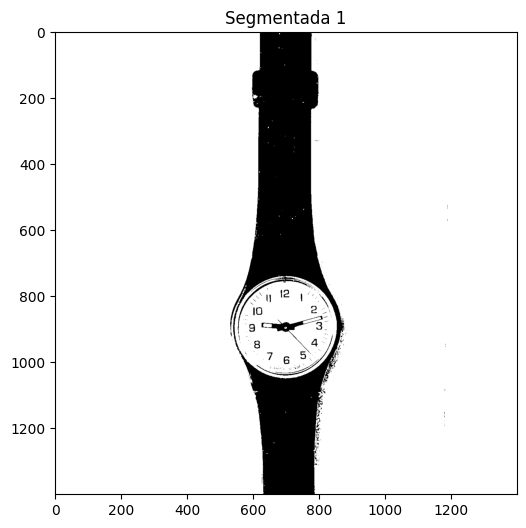

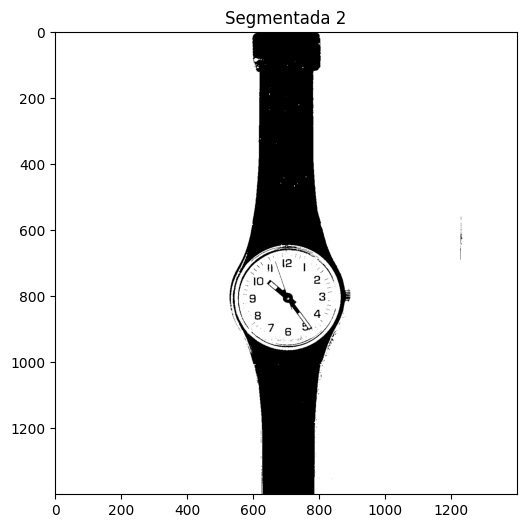

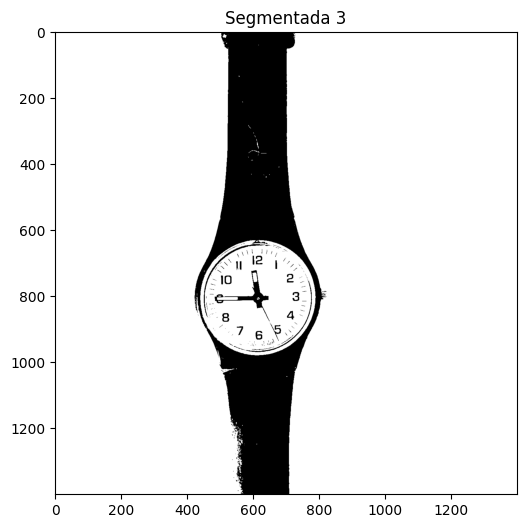

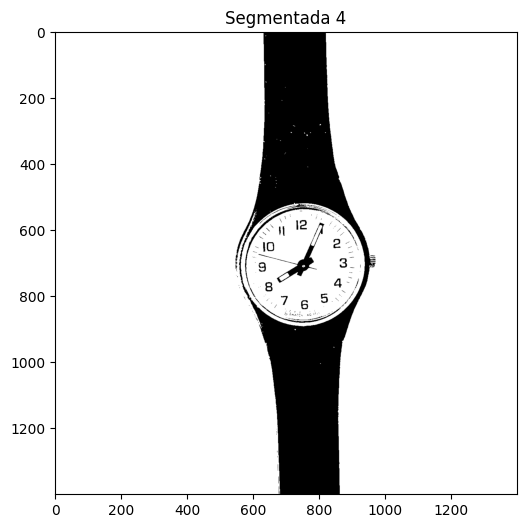

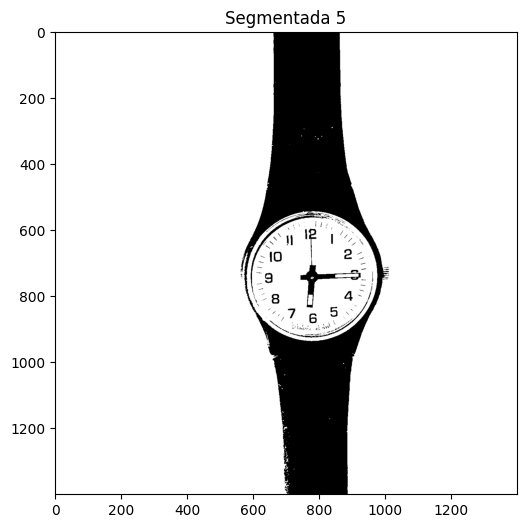

In [4]:
X_segmentadas = []  # Lista para guardar imágenes segmentadas

umbral = 35  # Umbral para separar fondo y objetos

for i, X in enumerate(X_grises, start=1):
    # Segmentación: píxeles oscuros = 0, píxeles claros = 255
    X_seg = np.where(X < umbral, 0, 255).astype(np.uint8)
    X_segmentadas.append(X_seg)

    # Mostrar imagen segmentada
    plt.figure(figsize=(6,6))
    plt.imshow(X_seg, cmap='gray')
    plt.title(f'Segmentada {i}')
    plt.show()

Como quedaron algunos pixeles remanentes, sobre todo en el fondo que tenia algunas sombras por el papel que estaba atras del reloj en la imagen original entonces hice una impieza de objetos pequeños o de pixeles remantes como el visto en clases para dejar solo reloj + correa.

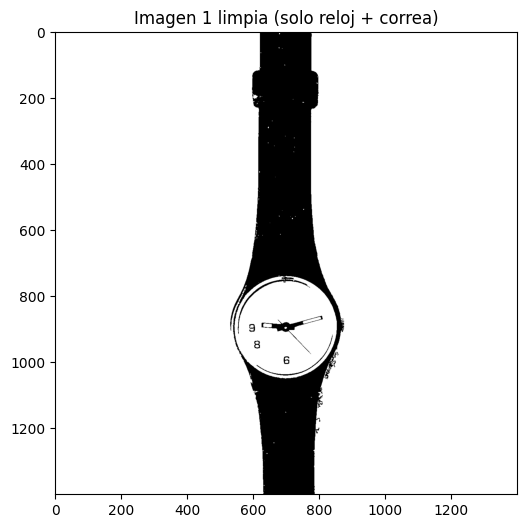

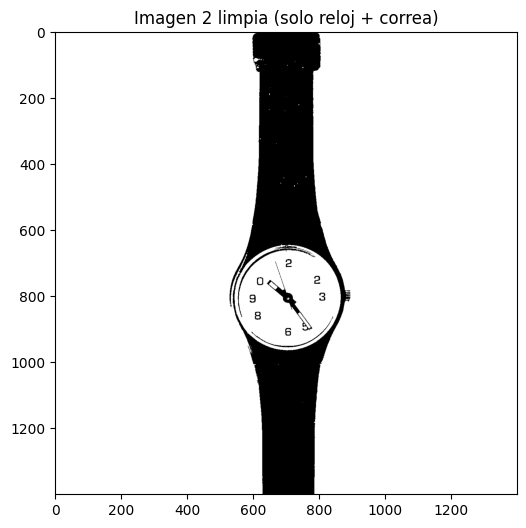

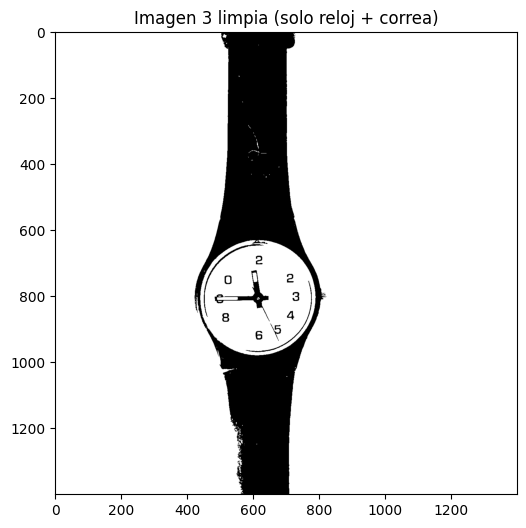

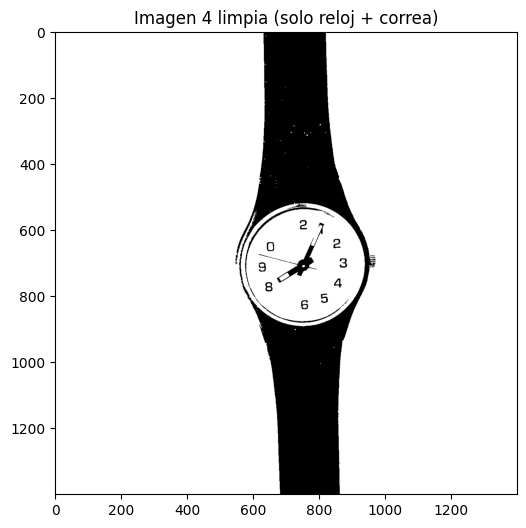

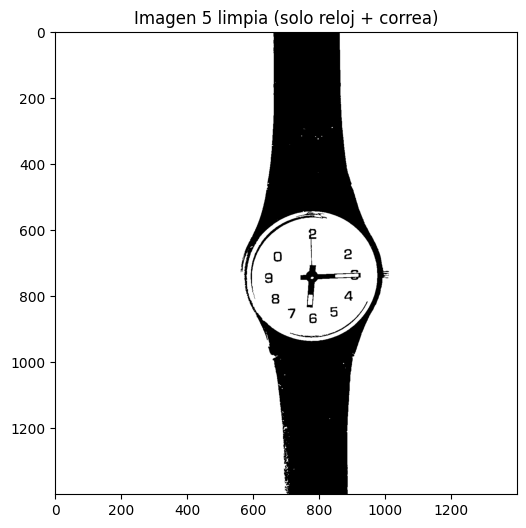

In [5]:
def limpiar_reloj(X_seg, min_pixeles=200):
    """
    Elimina objetos pequeños de la imagen binaria, dejando solo
    los elementos grandes (reloj y correa).
    """
    N, M = X_seg.shape
    X_limpia = np.ones((N,M), np.uint8)*255  # Fondo blanco
    X_temp = X_seg.copy()
    etiqueta = 1
    etiquetas = np.zeros((N,M), np.int32)

    # Recorremos la imagen buscando componentes conectados
    for r in range(N):
        for c in range(M):
            if X_temp[r,c]==0 and etiquetas[r,c]==0:
                queue = [(r,c)]
                etiquetas[r,c] = etiqueta
                count = 0
                while queue:
                    rr, cc = queue.pop(0)
                    count += 1
                    for dr in [-1,0,1]:
                        for dc in [-1,0,1]:
                            nr = rr+dr
                            nc = cc+dc
                            if 0<=nr<N and 0<=nc<M and X_temp[nr,nc]==0 and etiquetas[nr,nc]==0:
                                queue.append((nr,nc))
                                etiquetas[nr,nc] = etiqueta
                # Guardar solo componentes grandes
                if count >= min_pixeles:
                    X_limpia[etiquetas==etiqueta] = 0
                etiqueta += 1
    return X_limpia

X_limpias = [limpiar_reloj(X_seg) for X_seg in X_segmentadas]

# Mostrar las imágenes limpias
for i, X_limpia in enumerate(X_limpias, start=1):
    plt.figure(figsize=(6,6))
    plt.imshow(X_limpia, cmap='gray')
    plt.title(f'Imagen {i} limpia (solo reloj + correa)')
    plt.show()

Ahora que tenia la imagen segmentada solo con el reloj, entonces buscaba hacer un codigo que determinara el centro del reloj para luego definir las puntas de las manecillas y definir el angulo que formaban entre estos.La idea de mi codigo era primero encuentrar todos los píxeles negros del reloj. Luego calcular la mediana de las columnas para encontrar un centro horizontal aproximado, porque la mediana coincide con el punto medio de la correa del reloj, que suele estar alineado con el centro del reloj. Después, buscar el píxel negro más alejado horizontalmente para ubicar la coordenada vertical del centro, esto funciona porque el reloj es circular y el píxel más alejado horizontalmente está cerca del borde del reloj donde el radio es horizontal. Si este punto no está sobre un píxel negro, se corrige tomando el píxel negro más cercano. al iterar tuve que ajustar un poco hacia abajo con un despl_vertical para ubicar mejor el centro vertical ya que en todas las imagenes quedaba el centro un poco mas arriba de donde debia estar.

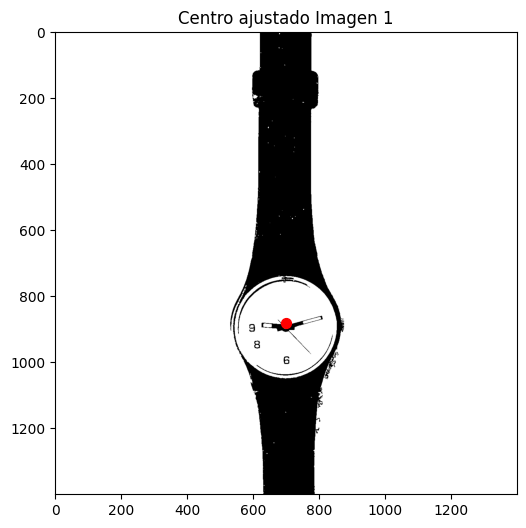

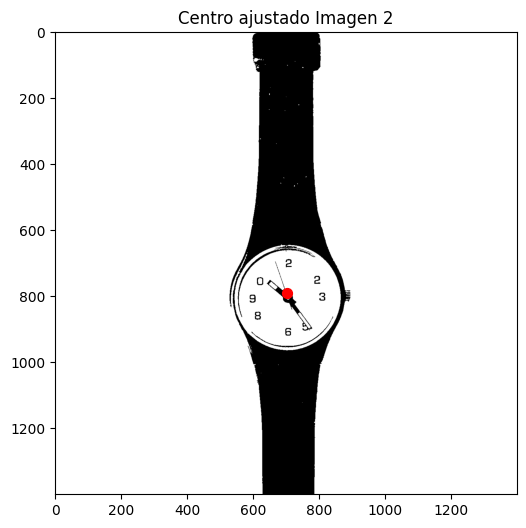

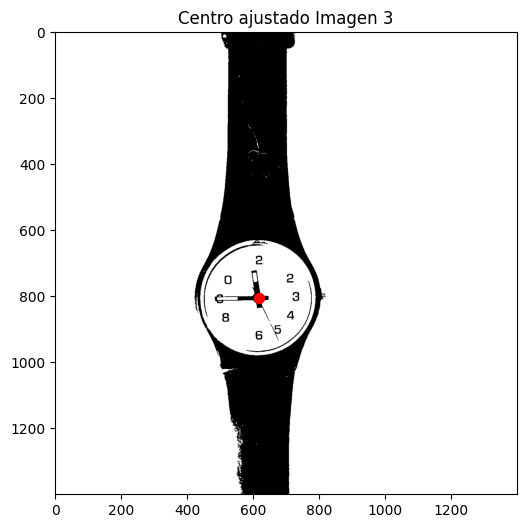

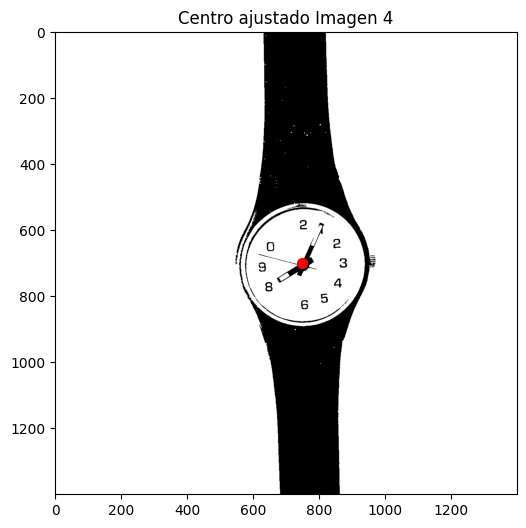

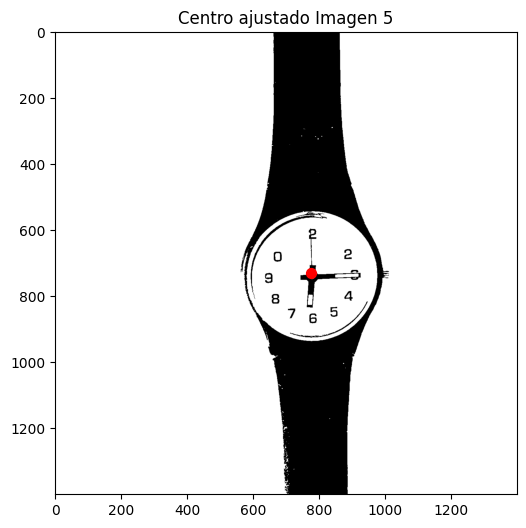

In [6]:
despl_vertical = 5  # Ajuste vertical del centro
centros_i, centros_j = [], []

for i, X in enumerate(X_limpias, start=1):
    filas_neg, cols_neg = np.where(X == 0)  # Píxeles negros
    j_centro = int(np.median(cols_neg))
    dist_horiz = np.abs(cols_neg - j_centro)
    idx_max = np.argmax(dist_horiz)
    i_centro = filas_neg[idx_max] + despl_vertical

    # Ajustar centro si no es negro
    if X[i_centro, j_centro] != 0:
        d2 = (filas_neg - i_centro)**2 + (cols_neg - j_centro)**2
        idx_min = np.argmin(d2)
        i_centro = filas_neg[idx_min]
        j_centro = cols_neg[idx_min]

    centros_i.append(i_centro)
    centros_j.append(j_centro)

    plt.figure(figsize=(6,6))
    plt.imshow(X, cmap='gray')
    plt.scatter([j_centro], [i_centro], c='red', s=50)
    plt.title(f'Centro ajustado Imagen {i}')
    plt.show()

Para dejar solo las manecillas hize un codigo para conservar solo los píxeles conectados al centro tanto por si mismos como por medio de otros pixeles.

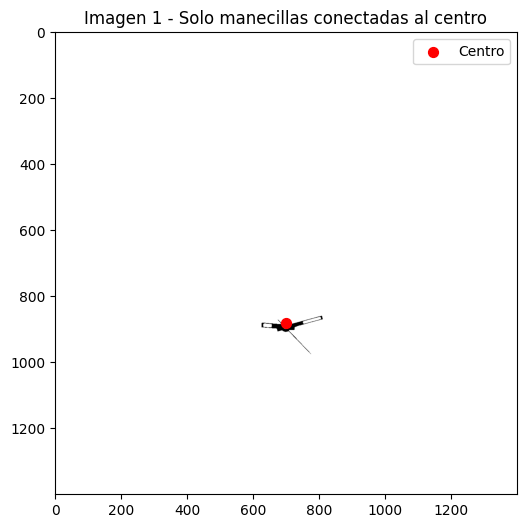

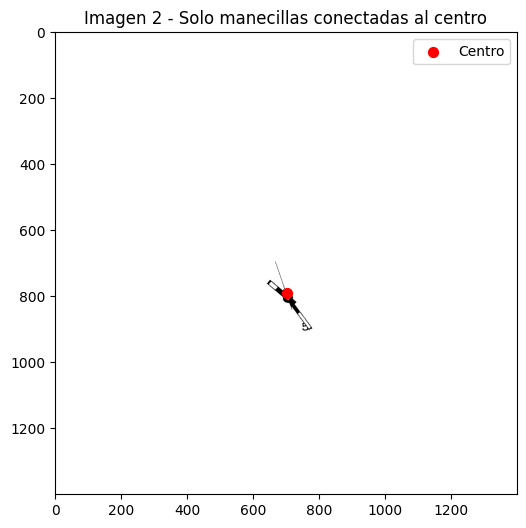

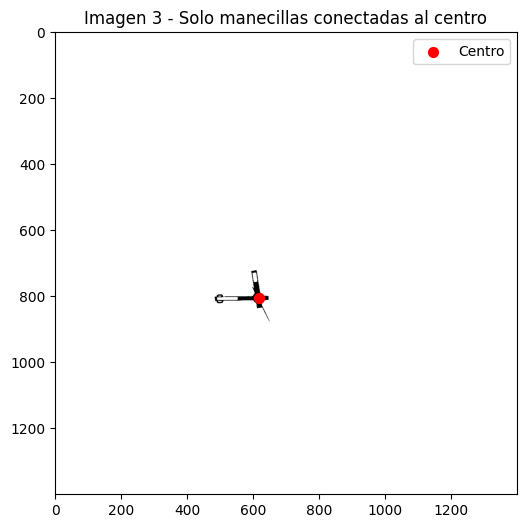

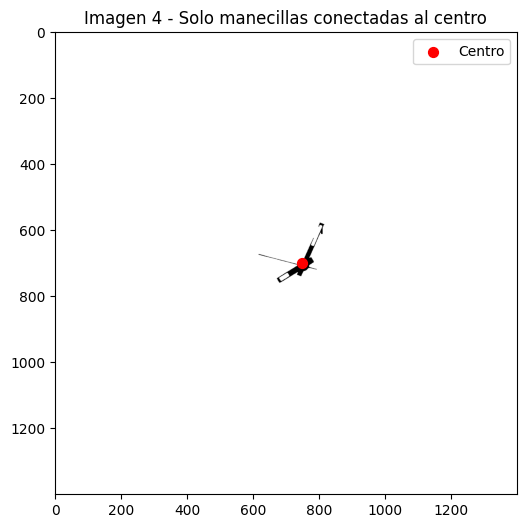

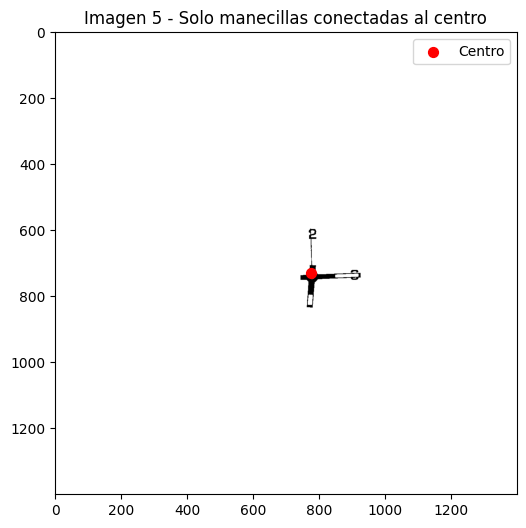

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def conservar_conectados_al_centro(X, i_c, j_c):
    """
    Mantiene solo los píxeles negros que están conectados al centro.
    Usa conectividad 8 (vecinos adyacentes y diagonales).
    """
    N, M = X.shape
    mask = np.zeros((N, M), np.uint8)  # Máscara de píxeles conectados
    stack = [(i_c, j_c)]  # Pila para recorrer píxeles conectados

    while stack:
        r, c = stack.pop()
        if 0 <= r < N and 0 <= c < M:
            if X[r, c] == 0 and mask[r, c] == 0:
                mask[r, c] = 1  # Marcar como conectado
                # Agregar todos los vecinos 8-conectados
                for dr in [-1,0,1]:
                    for dc in [-1,0,1]:
                        if dr != 0 or dc != 0:
                            stack.append((r+dr, c+dc))

    # Crear imagen final: fondo blanco, solo conectados en negro
    X_final = np.ones((N, M), np.uint8) * 255
    X_final[mask == 1] = 0
    return X_final

# Aplicar a todas las imágenes limpias
relojes_maneillas = []
for i, X_limpia in enumerate(X_limpias, start=1):
    i_centro = centros_i[i-1]
    j_centro = centros_j[i-1]
    X_maneillas = conservar_conectados_al_centro(X_limpia, i_centro, j_centro)
    relojes_maneillas.append(X_maneillas)

    # Visualización del resultado
    plt.figure(figsize=(6,6))
    plt.imshow(X_maneillas, cmap='gray')
    plt.scatter([j_centro], [i_centro], c='red', s=50, label='Centro')
    plt.title(f'Imagen {i} - Solo manecillas conectadas al centro')
    plt.legend()
    plt.show()

Ahora que tenemos solo las manecillas, tenemos que determinar cual es la de minutos y horas (las gruesas, con la de hora la mas corta) y la segundos la mas delgada poniendo un punto entre cada una, luego calcular el angulo que forma con respecto a ala vertical hacia arriba la linea desde el centro a las manecillas, sin considerar la de segundos.luego con respecto al angulo calcular la hora y minutos que marca el reloj.

Imagen 1: Hora aproximada = 09:14


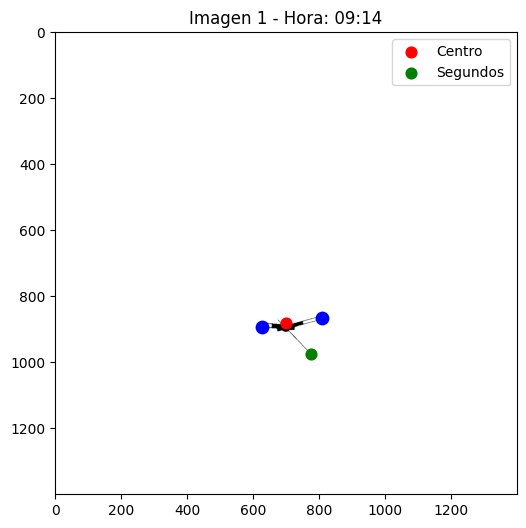

Imagen 2: Hora aproximada = 10:25


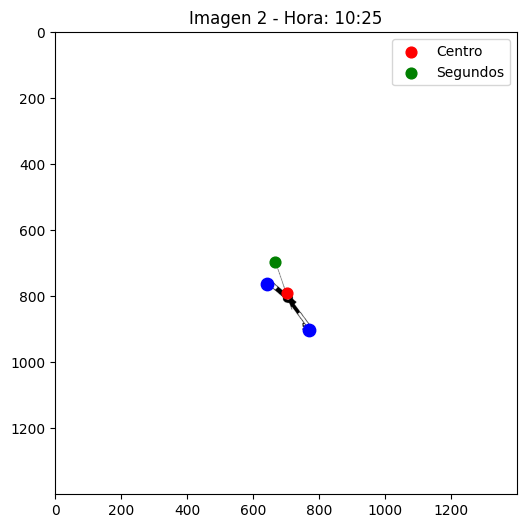

Imagen 3: Hora aproximada = 11:45


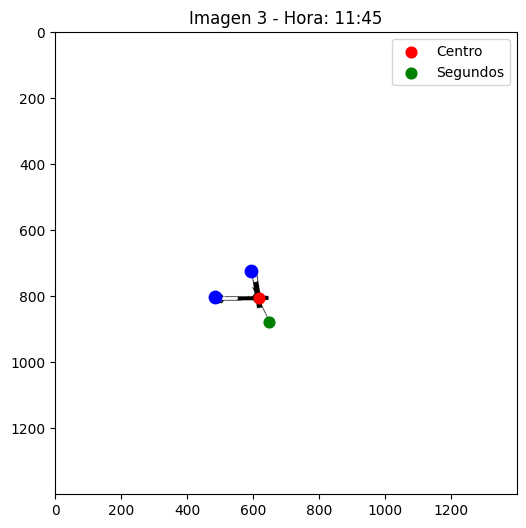

Imagen 4: Hora aproximada = 08:05


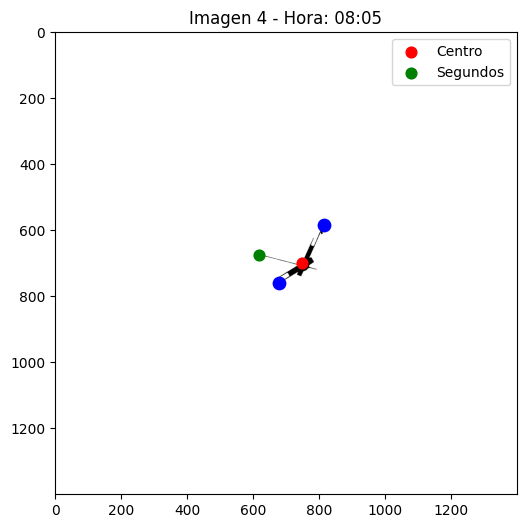

Imagen 5: Hora aproximada = 06:16


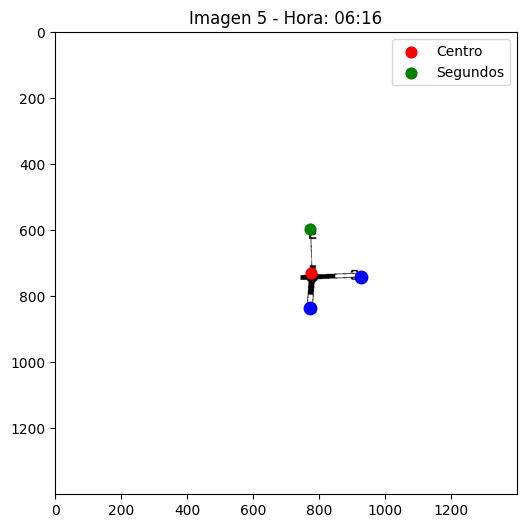

In [8]:
# ========================================================
# Celda 8 simplificada: Detección de manecillas y cálculo de hora
# ========================================================

def angulo_pixel(i_pixel, j_pixel, i_c, j_c):
    """Ángulo respecto al centro, 0 = 12:00, sentido horario"""
    dx, dy = j_pixel - j_c, -(i_pixel - i_c)
    ang = (np.pi/2 - np.arctan2(dy, dx)) % (2*np.pi)
    return np.degrees(ang)

for idx, X_m in enumerate(relojes_maneillas, start=1):
    i_c, j_c = centros_i[idx-1], centros_j[idx-1]
    filas, cols = np.where(X_m == 0)
    if len(filas) == 0: continue

    # Distancia y ángulo de cada píxel
    dist = np.sqrt((filas-i_c)**2 + (cols-j_c)**2)
    angs = np.array([angulo_pixel(r, c, i_c, j_c) for r,c in zip(filas, cols)])

    # Elegir 3 píxeles más lejanos, separados angularmente
    idx_orden = np.argsort(-dist)
    seleccion, ang_sel = [], []
    for idx_pix in idx_orden:
        if all(abs((angs[idx_pix]-a+180)%360-180) >= 12 for a in ang_sel):
            seleccion.append(idx_pix)
            ang_sel.append(angs[idx_pix])
        if len(seleccion) >= 3: break

    # Eliminar el más delgado (segundos)
    grosor = np.array([np.sum((angs>=a-5)&(angs<=a+5)) for a in ang_sel])
    idx_seg = np.argmin(grosor)
    idx_final = [i for j,i in enumerate(seleccion) if j!=idx_seg]

    # Identificar horas y minutos según distancia
    dist_final = dist[idx_final]
    if dist_final[0] > dist_final[1]:
        mano_min, mano_hora = idx_final[0], idx_final[1]
    else:
        mano_min, mano_hora = idx_final[1], idx_final[0]

    minuto = int(round(angs[mano_min]/6)) % 60
    hora = int(round(angs[mano_hora]/30)) % 12
    if hora == 0: hora = 12

    print(f"Imagen {idx}: Hora aproximada = {hora:02d}:{minuto:02d}")

    # Visualización final
    plt.figure(figsize=(6,6))
    plt.imshow(X_m, cmap='gray')
    plt.scatter([j_c], [i_c], c='red', s=60, label='Centro')
    plt.scatter(cols[idx_final], filas[idx_final], c='blue', s=80)
    plt.scatter(cols[seleccion[idx_seg]], filas[seleccion[idx_seg]], c='green', s=60, label='Segundos')
    plt.title(f"Imagen {idx} - Hora: {hora:02d}:{minuto:02d}")
    plt.legend()
    plt.show()
